#Import Libraries

In [ ]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, loss_ddqn

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
from gym.wrappers import FrameStack
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

In [ ]:
device

device(type='cpu')

#1 - Tuning the DQN

##1.1 - Hyperparameters

###Function to train the model

In [ ]:
NUM_RUNS = 10
EPSILON = 1      

NUM_EPISODES = 500
BATCH_SIZE = 256
GAMMA = 0.999
SYNC_TARGET=75
BUFFER_SIZE = 125000

epsilon_type = "exponential_decay"
EPSILON_PARAMETER = 0.985

if epsilon_type == "linear_decay":
    EPSILON_LINEAR_DECAY = EPSILON_PARAMETER
elif epsilon_type == "exponential_decay":
    EPSILON_EXPONENTIAL_DECAY = EPSILON_PARAMETER
elif epsilon_type == "exponential_decay_2":
    EPSILON_START = EPSILON_PARAMETER[0]
    EPS_END = 0.01
    EPS_DECAY = EPSILON_PARAMETER[1]
elif epsilon_type == "constant_epsilon":
    EPSILON_START = EPSILON_PARAMETER

EPSILON_START = 1
EPSILON_MIN = 0.01

k = 2
num_hidden_layers = 3
size_hidden_layers = 75

In [ ]:
# Function for model training

def train_model(model_name="dqn", epsilon_type="exponential_decay", NUM_ITERATIONS=10, NUM_EPISODES=500, BATCH_SIZE=256, SYNC_TARGET=75,
                EPSILON_PARAMETER=0.985, BUFFER_SIZE=125000, k=2, use_early_stopping=True, target_update="step",
                num_hidden_layers=3, size_hidden_layers=75, loss_reduction="sum"):
  print(locals())
  runs_results = []
  epsilon_values= np.zeros((NUM_EPISODES, NUM_ITERATIONS))
  
  EPSILON_START = 1
  EPSILON_MIN = 0.01
  
  if epsilon_type == "linear_decay":
    EPSILON_LINEAR_DECAY = EPSILON_PARAMETER
  elif epsilon_type == "exponential_decay":
      EPSILON_EXPONENTIAL_DECAY = EPSILON_PARAMETER
  elif epsilon_type == "exponential_decay_2":
      EPSILON_START = EPSILON_PARAMETER[0]
      EPS_END = 0.01
      EPS_DECAY = EPSILON_PARAMETER[1]
  elif epsilon_type == "constant_epsilon":
      EPSILON_START = EPSILON_PARAMETER

  for run in tqdm(range(NUM_ITERATIONS)):
      env = gym.make('CartPole-v1')
      env = FrameStack(env, k, new_step_api=True)
      # print(f"Starting run {run+1} of {NUM_RUNS}")
      policy_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)
      target_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)

      update_target(target_net, policy_net)
      target_net.eval()

      optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)
      memory = ReplayBuffer(BUFFER_SIZE)

      steps_done = 0
      printed_message = False
      early_stopping = 0
      EPSILON = EPSILON_START
      episode_durations = []
      
      for i_episode in tqdm(range(NUM_EPISODES)):
          # if (i_episode+1) % 50 == 0:
          #     print("episode ", i_episode+1, "/", 300)

          observation = env.reset()
          state = torch.tensor(observation).float().view(-1).to(device)

          done = False
          terminated = False
          t = 0
          
          while not (done or terminated):
              if epsilon_type == "exponential_decay_2":
                EPSILON = EPS_END + (EPSILON_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
              
              # Select and perform an action
              action = epsilon_greedy(EPSILON, policy_net, state)

              observation, reward, done, terminated, _ = env.step(action)
              reward = torch.tensor([reward], device=device)
              action = torch.tensor([action], device=device)
              next_state = torch.tensor(observation).reshape(-1).float().to(device)
          
              steps_done += 1
              memory.push([state, action, next_state, reward, torch.tensor([done], device=device)])
              
              # Move to the next state
              state = next_state

              # Perform one step of the optimization (on the policy network)
              if early_stopping < 5:
                if not len(memory.buffer) < BATCH_SIZE:
                    transitions = memory.sample(BATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    
                    # Optimize the model
                    if model_name=="dqn":
                        mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones, reduction=loss_reduction)
                    elif model_name=="ddqn":
                        mse_loss = loss_ddqn(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones, reduction=loss_reduction)
  
                    optimizer.zero_grad()
                    mse_loss.backward()

                    # Limit magnitude of gradient for update step
                    for param in policy_net.parameters():
                        param.grad.data.clamp_(-1, 1)

                    optimizer.step()

              elif not printed_message:
                  print("Early stopping - episode ", i_episode)
                  printed_message = True

              if target_update=="step":
                if steps_done % SYNC_TARGET == 0:
                    update_target(target_net, policy_net) 
              
              if done or terminated:
                  episode_durations.append(t + 1)
                
              
              t += 1

          if epsilon_type == "exponential_decay":
              EPSILON = max(EPSILON*EPSILON_EXPONENTIAL_DECAY, EPSILON_MIN)
          elif epsilon_type == "linear_decay":
              EPSILON = max(EPSILON_START - EPSILON_LINEAR_DECAY*i_episode, EPSILON_MIN)
          epsilon_values[i_episode, run]=EPSILON
          if use_early_stopping:
            if t == 500:
                  early_stopping += 1
          if target_update=="episode":
            if i_episode % SYNC_TARGET == 0: 
              update_target(target_net, policy_net)

      runs_results.append(episode_durations)
  print('Complete')

  return runs_results, epsilon_values

###Number of frames

In [ ]:
def vary_frame_number():
  
  k_values = [1,2,4,10]
  colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  plt.figure(figsize = (12, 8))

  for c, k in enumerate(k_values):

      runs_results, _ = train_model(k=k)

      results = torch.tensor(runs_results)
      mean_rewards = results.float().mean(0)
      std_rewards = results.float().std(0)
      
      plt.plot(episodes, mean_rewards, color=colors[c], label=f"k = {k}");
      plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
  
      
  plt.title('Effect of parameter k on DQN\'s learning curve', fontsize =20)
  plt.xlabel('Episode',fontsize =16)
  plt.ylabel('Total non-discounted \n sum of reward', fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend(fontsize =16)
  plt.show()

{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 1, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  191


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  253


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  105


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  206


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  161


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  71


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  207


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  203


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  155


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  171
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  224


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  165


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  264


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  95


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  128


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  217


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  228


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  207


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  195


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  183
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 4, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  140


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  192


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  223


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  212


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  163


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  147


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  152


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  178


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  159


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  235
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 10, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  184


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  142


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  242


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  182


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  200


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  211


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  223


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  161


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  161


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  196
Complete


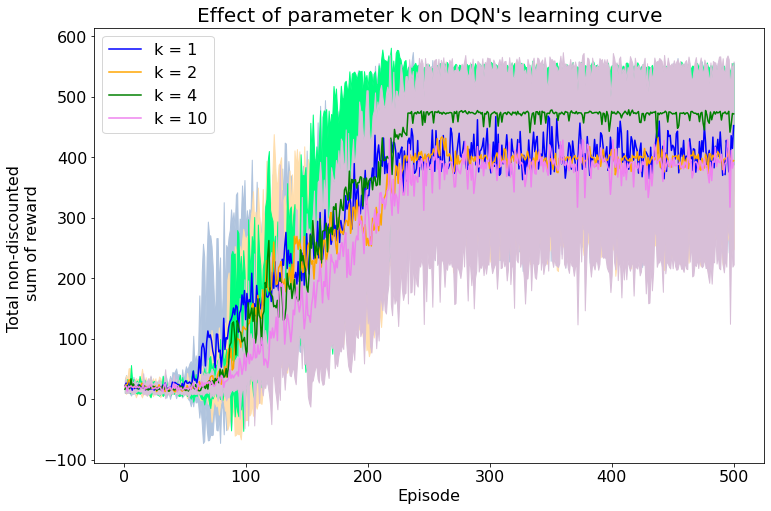

In [ ]:
vary_frame_number()

###Buffer size

In [ ]:
def vary_replay_buffer():

  buffer_sizes = [256,1000,10000,100000,500000]

  results_buffer = dict()
  

  for c, size in enumerate(buffer_sizes):

      runs_results, _ = train_model(BUFFER_SIZE=size)
      results_buffer[size]=runs_results

  colors = ['blue', 'orange', 'green', 'violet', 'fuchsia', 'gray']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'plum', 'lightgray']

  plt.figure(figsize = (12, 8));
  episodes = list(range(1,NUM_EPISODES+1))

  for c, buffer_size in enumerate(results_buffer.keys()):
    runs_results = results_buffer[buffer_size]
    results = torch.tensor(runs_results)
    mean_rewards = results.float().mean(0)
    std_rewards = results.float().std(0)
  
    plt.plot(episodes, mean_rewards, color=colors[c], label='buffer size = ' + str(buffer_size));
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
    plt.title('Effect of buffer size on Learning Curve for DQN model', fontsize =20);
   
  plt.xlabel('Episode',fontsize =16);
  plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
  plt.xticks(fontsize=16);
  plt.yticks(fontsize=16);
  plt.legend(fontsize =16);
  plt.show()

  return results_buffer

In [ ]:
results = vary_replay_buffer()

###Batch size

In [ ]:
def vary_batch_size():
  
  size = [32, 256, 512]
  colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  plt.figure(figsize = (12, 8))

  for c, size in enumerate(size):

      runs_results, _ = train_model(BATCH_SIZE=size)

      results = torch.tensor(runs_results)
      mean_rewards = results.float().mean(0)
      std_rewards = results.float().std(0)
      
      plt.plot(episodes, mean_rewards, color=colors[c], label=f"batch size = {size}");
      plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
  
      
  plt.title('Effect of batch size on DQN\'s learning curve', fontsize =20)
  plt.xlabel('Episode',fontsize =16)
  plt.ylabel('Total non-discounted \n sum of reward', fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend(fontsize =16)
  plt.show()

{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 32, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  409


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  292
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  228


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  203


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  173


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  178


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  226


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  160


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  123


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  172


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  201


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  100
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 512, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  151


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  258


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  208


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  150


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  200


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  115


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  214


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  197


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  111


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  203
Complete


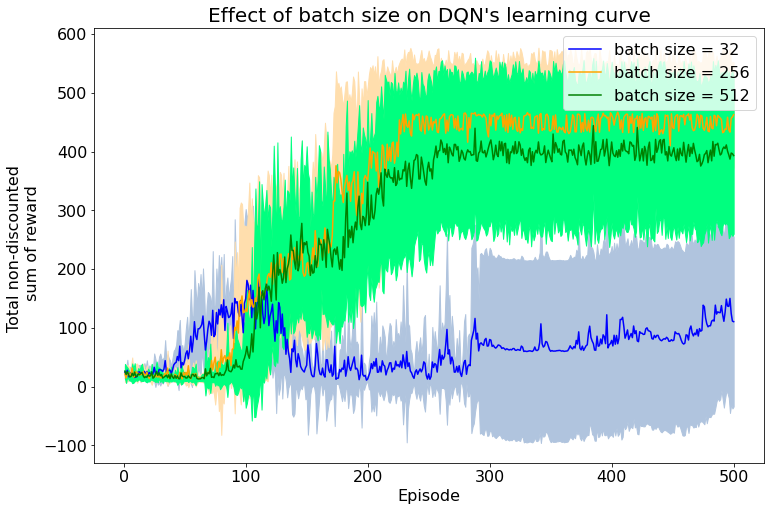

In [ ]:
vary_batch_size()

###Target update frequency

In [ ]:
colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))

runs_results, _ = train_model(target_update="episode", SYNC_TARGET=10)
results = torch.tensor(runs_results)
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[0], label=f"update after 10 episodes");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[0]);

results = torch.tensor(comparison_results["DQN"])
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[1], label="update after 75 steps");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[1]);

plt.title('Impact of early stopping on DQN model\'s performance', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

In [ ]:
def vary_update_frequency():
  
  frequency = [20, 75, 1000]
  colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  plt.figure(figsize = (12, 8))

  for c, f in enumerate(frequency):

      runs_results, _ = train_model(SYNC_TARGET=f, NUM_ITERATIONS=3)

      results = torch.tensor(runs_results)
      mean_rewards = results.float().mean(0)
      std_rewards = results.float().std(0)
      
      plt.plot(episodes, mean_rewards, color=colors[c], label=f"update frequency = every {f} steps");
      plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
  
      
  plt.title('Effect of target update frequency on DQN\'s learning curve', fontsize =20)
  plt.xlabel('Episode',fontsize =16)
  plt.ylabel('Total non-discounted \n sum of reward', fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend(fontsize =16)
  plt.show()


In [ ]:
vary_update_frequency()

###Number of neurons in hidden layers

In [ ]:
def vary_neurons_number():
  
  neuron_values = [10, 50, 75, 100]
  colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  plt.figure(figsize = (12, 8))

  for c, n in enumerate(neuron_values):

      runs_results, _ = train_model(size_hidden_layers=n)

      results = torch.tensor(runs_results)
      mean_rewards = results.float().mean(0)
      std_rewards = results.float().std(0)
      
      plt.plot(episodes, mean_rewards, color=colors[c], label=f"{n} neurons per hidden layer");
      plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
  
      
  plt.title('Effect of number of neurons per hidden layer on DQN\'s learning curve', fontsize =20)
  plt.xlabel('Episode',fontsize =16)
  plt.ylabel('Total non-discounted \n sum of reward', fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend(fontsize =16)
  plt.show()

{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 10, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  242


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  187


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  136


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  401


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  188


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  290


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  341


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  299


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  406
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 50, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  243


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  130


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  212


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  177


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  157


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  89


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  131


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  94


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  123


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  280
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  209


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  223


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  125


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  246


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  158


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  164


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  147


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  183


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  184


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  170
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 100, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  175


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  149


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  124


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  115


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  197


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  167


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  203


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  101


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  161


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  234
Complete


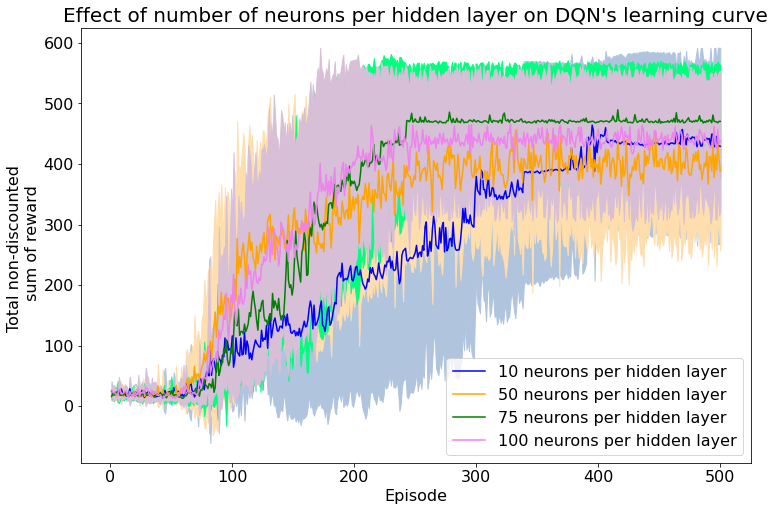

In [ ]:
vary_neurons_number()

###Number of layers

In [ ]:
def vary_layer_number():
  
  layer_values = [1,2,3,4]
  colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  plt.figure(figsize = (12, 8))

  for c, l in enumerate(layer_values):

      runs_results, _ = train_model(num_hidden_layers=l)

      results = torch.tensor(runs_results)
      mean_rewards = results.float().mean(0)
      std_rewards = results.float().std(0)
      
      plt.plot(episodes, mean_rewards, color=colors[c], label=f"{l} hidden layers");
      plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);
  
      
  plt.title('Effect of number of hidden layers on DQN\'s learning curve', fontsize =20)
  plt.xlabel('Episode',fontsize =16)
  plt.ylabel('Total non-discounted \n sum of reward', fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend(fontsize =16)
  plt.show()

{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 1, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  138


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  157


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  200


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  106


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  78


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  347


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  131


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  128


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  238


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  312
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 2, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  150


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  149


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  139


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  89


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  167


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  217


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  205


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  412


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  124
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  157


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  210


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  218


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  156


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  195


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  213


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  190


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  142


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  194


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  174
Complete
{'model_name': 'dqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 2, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 4, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  231


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  233


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  189


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  259


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  275


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  225


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  204


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  399


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  198
Complete


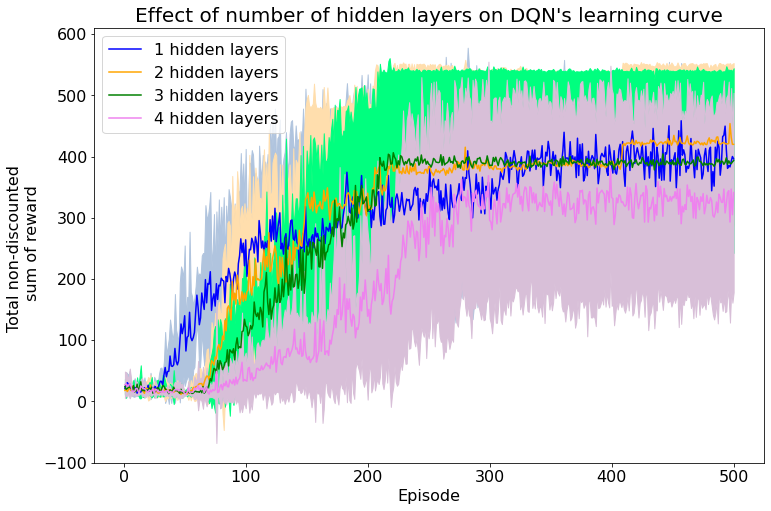

In [ ]:
vary_layer_number()

###Early stopping

In [ ]:
colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))

runs_results, _ = train_model(use_early_stopping=False, NUM_ITERATIONS=10)
results = torch.tensor(runs_results)
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[0], label=f"without early stopping");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[0]);

results = torch.tensor(comparison_results["DQN"])
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[1], label="with early stopping");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[1]);

plt.title('Impact of early stopping on DQN model\'s performance', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

###Loss function

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  207


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  194


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  258


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  246


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  256


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  169


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  198


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  195


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  258


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  198
Complete


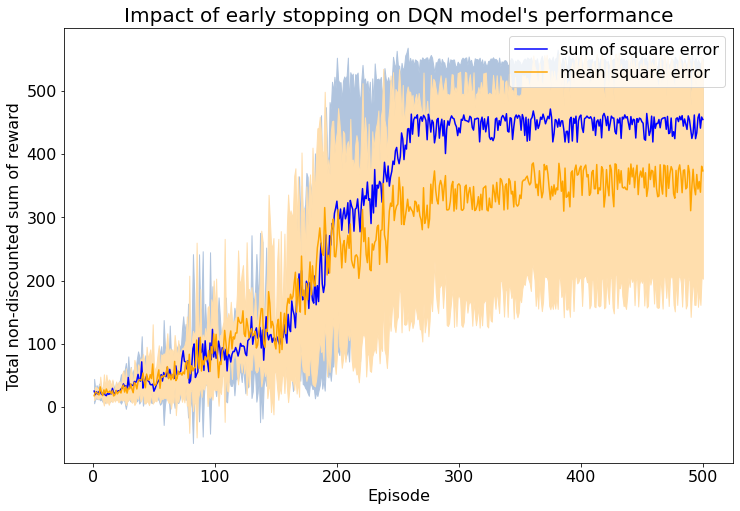

In [ ]:
colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))

runs_results, _ = train_model(reduction="mean", NUM_ITERATIONS=10)
results = torch.tensor(runs_results)
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[0], label=f"mean square error");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[0]);

results = torch.tensor(comparison_results["DQN"])
mean_rewards = results.float().mean(0)
std_rewards = results.float().std(0)

plt.plot(episodes, mean_rewards, color=colors[1], label="sum square error");
plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[1]);

plt.title('Impact of loss function on DQN model\'s performance', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

##1.2- Exploration

In [ ]:

# constant epsilon
epsilon_constants = [0.9, 0.5, 0.1]

# linear_decay
epsilon_linear_decays = [0.004, 0.002]

# exponential_decay
epsilon_exponential_decays = [0.985, 0.5]

# exponential_decay_2
# epsilon_decays = [(0.8,1000), (0.8,15000), (0.5,1000), (0.5, 15000)]

epsilon_parameters = dict()
epsilon_parameters["constant_epsilon"]= epsilon_constants
epsilon_parameters["linear_decay"]= epsilon_linear_decays
epsilon_parameters["exponential_decay"]=epsilon_exponential_decays 
# epsilon_parameters["exponential_decay_2"]= epsilon_decays


def vary_epsilon():

  model_name = "dqn"
  # epsilon_types = ["constant_epsilon", "linear_decay", "exponential_decay", "exponential_decay_2"]
  epsilon_types = ["constant_epsilon", "linear_decay", "exponential_decay"]
  colors = ['blue', 'orange', 'green', 'violet', 'fuchsia']
  std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'plum']
  episodes = list(range(1,NUM_EPISODES+1))

  # fig, axs = plt.subplots(figsize = (25,10), ncols = 4, nrows = 2, sharex=True, sharey='row')
  fig, axs = plt.subplots(figsize = (25,10), ncols = 3, nrows = 2, sharex=True, sharey='row')
  axs = axs.ravel()

  results_epsilon = dict()

  for c, epsilon_type in enumerate(tqdm(epsilon_types)):

      for d, param in enumerate(epsilon_parameters[epsilon_type]):
        results, epsilon_values = train_model(epsilon_type=epsilon_type, 
        EPSILON_PARAMETER=param)

        epsilon_values= epsilon_values[:, 0]

        results_epsilon[epsilon_type+"_"+str(param)]=dict()
        results_epsilon[epsilon_type+"_"+str(param)]['reward']=results
        results_epsilon[epsilon_type+"_"+str(param)]['epsilon']=epsilon_values

        results = torch.tensor(results)
        mean_rewards = results.float().mean(0)
        std_rewards = results.float().std(0)
        
        axs[c].plot(episodes, mean_rewards, color=colors[d]);
        axs[c].fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[d]);
        
        if epsilon_type== "linear_decay":
            label=r"$ϵ$ = $ϵ$_start - $ϵ$_decay * episode" 
        elif epsilon_type== "exponential_decay":
            label=r"$ϵ$ = $ϵ$_decay$^{episode}$" 
        elif epsilon_type== "exponential_decay_2":
            label = r"$ϵ$ = $ϵ$_end + ($ϵ$_start-$ϵ$_end) * $\epsilon^{-{\frac{steps}{\epsilon _decay}}}$"
        elif epsilon_type== "constant_epsilon":
            label=r"$ϵ$ = constant" 

        axs[c].set_title(label)
        axs[c+3].plot(episodes, epsilon_values, color=colors[d],label=f"$ϵ$ parameter = {param}");
        axs[c+3].legend(fontsize =16);

  fig.suptitle('Effect of $ϵ$ on Learning Curve for DQN model', fontsize =20);

  for i, ax in enumerate(axs.flat):
    if i<3:
      ax.set(xlabel='Episode', ylabel='Total non-discounted \n sum of reward')
    else:
      ax.set(xlabel='Episode', ylabel='Epsilon value')
    for item in ([ax.xaxis.label, ax.yaxis.label, ax.title] + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()

  plt.show()

  return results_epsilon

In [ ]:
results_epsilon = vary_epsilon()

##1.3- Learning curve

In [ ]:
# DQN model training

runs_results = []
epsilon_values= np.zeros((NUM_EPISODES, NUM_RUNS))

for run in tqdm(range(NUM_RUNS)):
    
    env = gym.make('CartPole-v1')
    env = FrameStack(env, k, new_step_api=True)

    # print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)
    target_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)

    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)
    memory = ReplayBuffer(BUFFER_SIZE)

    steps_done = 0
    printed_message = False
    early_stopping = 0
    EPSILON = EPSILON_START
    episode_durations = []
    
    for i_episode in tqdm(range(NUM_EPISODES)):
        # if (i_episode+1) % 50 == 0:
        #     print("episode ", i_episode+1, "/", 300)

        observation = env.reset()
        state = torch.tensor(observation).float().view(-1).to(device)

        done = False
        terminated = False
        t = 0
        
        while not (done or terminated):
            if epsilon_type == "exponential_decay_2":
              EPSILON = EPS_END + (EPSILON_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, _ = env.step(action)
            reward = torch.tensor([reward], device=device)
            action = torch.tensor([action], device=device)
            
            steps_done += 1

            # Observe new state
            next_state = torch.tensor(observation).reshape(-1).float().to(device)
            
            # print(steps_done, torch.tensor(observation), reward, done, terminated)

            memory.push([state, action, next_state, reward, torch.tensor([done], device=device)])
            
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if early_stopping < 5:
              if not len(memory.buffer) < BATCH_SIZE:
                  transitions = memory.sample(BATCH_SIZE)
                  state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                  
                  # Optimize the model
                  mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                  optimizer.zero_grad()
                  mse_loss.backward()

                  # Limit magnitude of gradient for update step
                  for param in policy_net.parameters():
                      param.grad.data.clamp_(-1, 1)

                  optimizer.step()

            elif not printed_message:
                print("Early stopping - episode ", i_episode)
                printed_message = True

            if steps_done % SYNC_TARGET == 0:
                update_target(target_net, policy_net) 
            
            if done or terminated:
                episode_durations.append(t + 1)
            
            t += 1

        if epsilon_type == "exponential_decay":
            EPSILON = max(EPSILON*EPSILON_EXPONENTIAL_DECAY, EPSILON_MIN)
        elif epsilon_type == "linear_decay":
            EPSILON = max(EPSILON_START - EPSILON_LINEAR_DECAY*i_episode, EPSILON_MIN)
        epsilon_values[i_episode, run]=EPSILON
        if t == 500:
              early_stopping += 1
    runs_results.append(episode_durations)
print('Complete')

comparison_results = dict()
comparison_results['DQN'] = runs_results

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Early stopping - episode  134


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  148


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  154


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  200


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  141


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  179


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  103


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  122


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  422


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  255
Complete


In [ ]:
path = "DQN_model.tar"
torch.save({
          'policy_network_state_dict': policy_net.state_dict(),
          'target_network_state_dict': target_net.state_dict(),
          'runs_results': runs_results,
          }, path)

print("saved checkpoint: ", path)

saved checkpoint:  DQN_model.tar


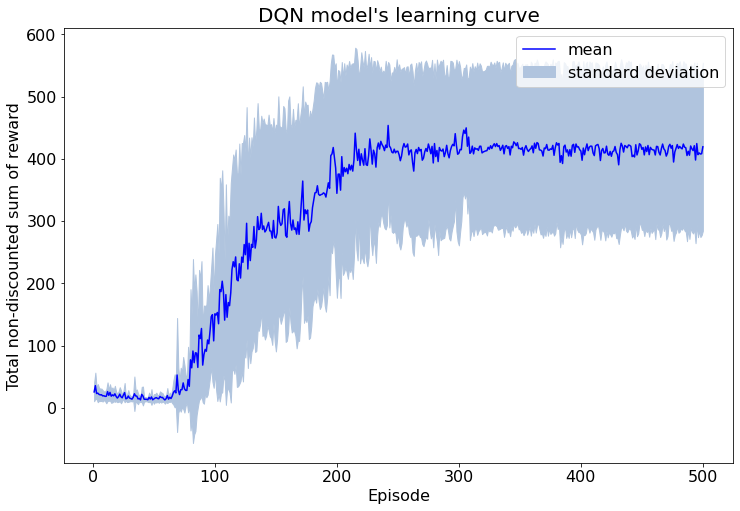

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))
plt.plot(episodes, means, color='blue', label='mean')
plt.fill_between(episodes, means-stds, means+stds, color = 'lightsteelblue', label= 'standard deviation')
plt.title('DQN model\'s learning curve', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

In [ ]:
max(means)

tensor(453.6000)

In [ ]:
torch.mean(means)

tensor(311.8804)

#2- Visualise your DQN policy

##Create policy with k=1

In [ ]:
# Train model with k=1
# DQN model training
k=1
runs_results = []
epsilon_values= np.zeros((NUM_EPISODES, NUM_RUNS))

for run in tqdm(range(NUM_RUNS)):
    
    env = gym.make('CartPole-v1')
    env = FrameStack(env, k, new_step_api=True)

    # print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)
    target_net = DQN([k*4] + [size_hidden_layers]*num_hidden_layers + [2]).to(device)

    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)
    memory = ReplayBuffer(BUFFER_SIZE)

    steps_done = 0
    printed_message = False
    early_stopping = 0
    EPSILON = EPSILON_START
    episode_durations = []
    
    for i_episode in tqdm(range(NUM_EPISODES)):
        # if (i_episode+1) % 50 == 0:
        #     print("episode ", i_episode+1, "/", 300)

        observation = env.reset()
        state = torch.tensor(observation).float().view(-1).to(device)

        done = False
        terminated = False
        t = 0
        
        while not (done or terminated):
            if epsilon_type == "exponential_decay_2":
              EPSILON = EPS_END + (EPSILON_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, _ = env.step(action)
            reward = torch.tensor([reward], device=device)
            action = torch.tensor([action], device=device)
            
            steps_done += 1

            # Observe new state
            next_state = torch.tensor(observation).reshape(-1).float().to(device)
            
                # print(steps_done, torch.tensor(observation), reward, done, terminated)

            memory.push([state, action, next_state, reward, torch.tensor([done], device=device)])
            
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if early_stopping < 5:
              if not len(memory.buffer) < BATCH_SIZE:
                  transitions = memory.sample(BATCH_SIZE)
                  state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                  
                  # Optimize the model
                  
                    # Compute loss
                    # bellman_targets = ((~dones).reshape(-1)*(target_net(nextstate_batch)).max(1).values * GAMMA) + (~dones).reshape(-1)*reward_batch.reshape(-1)
                    # q_values = policy_net(state_batch).gather(1, action_batch).reshape(-1)
                    # mse_loss =  ((q_values - bellman_targets)**2).mean()

                  mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                  optimizer.zero_grad()
                  mse_loss.backward()

                  # Limit magnitude of gradient for update step
                  for param in policy_net.parameters():
                      param.grad.data.clamp_(-1, 1)

                  optimizer.step()

            elif not printed_message:
                print("Early stopping - episode ", i_episode)
                printed_message = True

            if steps_done % SYNC_TARGET == 0:
                update_target(target_net, policy_net) 
            
            if done or terminated:
                episode_durations.append(t + 1)
            
            t += 1

        if epsilon_type == "exponential_decay":
            EPSILON = max(EPSILON*EPSILON_EXPONENTIAL_DECAY, EPSILON_MIN)
        elif epsilon_type == "linear_decay":
            EPSILON = max(EPSILON_START - EPSILON_LINEAR_DECAY*i_episode, EPSILON_MIN)
        epsilon_values[i_episode, run]=EPSILON
        if t == 500:
              early_stopping += 1
        # Update the target network, copying all weights and biases in DQN
        # if i_episode % 1 == 0: 
        #     update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

comparison_results = dict()
comparison_results['DQN with k=1'] = runs_results


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  163


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  187


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  177


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  200


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  118


  0%|          | 0/500 [00:01<?, ?it/s]

Early stopping - episode  130


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  235


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  189


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  201


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  98
Complete


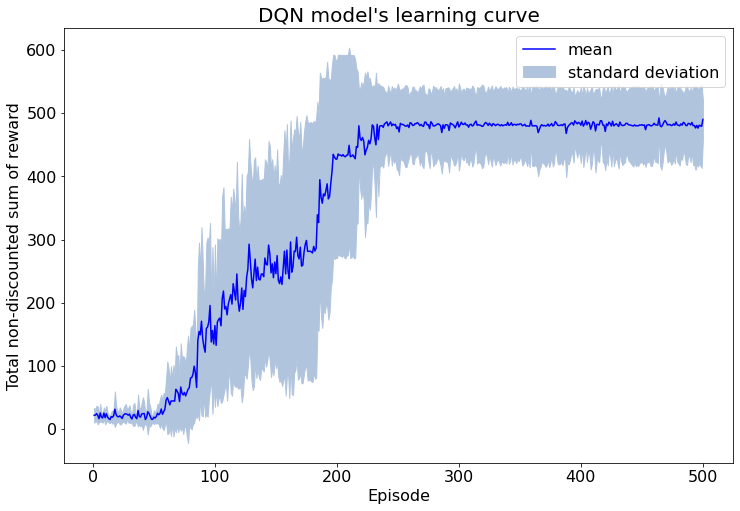

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))
plt.plot(episodes, means, color='blue', label='mean')
plt.fill_between(episodes, means-stds, means+stds, color = 'lightsteelblue', label= 'standard deviation')
plt.title('DQN model\'s learning curve', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

In [ ]:
print(max(means))
torch.mean(means)

tensor(492.5000)


tensor(350.3688)

In [ ]:
# Save DQN with k=1
path = "DQN_model_k1.tar"
torch.save({
          'policy_network_state_dict': policy_net.state_dict(),
          'target_network_state_dict': target_net.state_dict(),
          'runs_results': runs_results,
          }, path)

print("saved checkpoint: ", path)

saved checkpoint:  DQN_model_k1.tar


##2.1- Slices of the greedy policy action

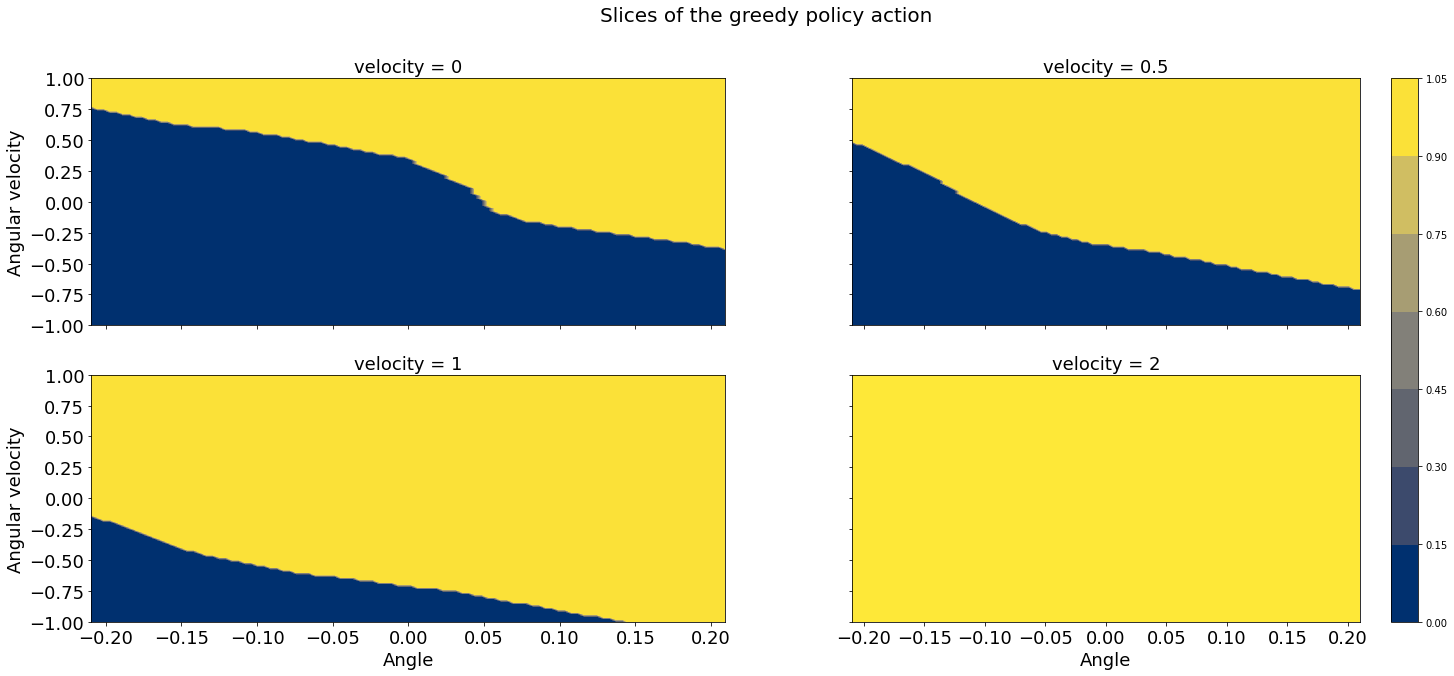

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net   # randomly initialised, replace with your trained DQN
q = False    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))


fig, axs = plt.subplots(figsize = (25,10), ncols = 2, nrows = 2, sharex=True, sharey='row')
axs = axs.ravel()
velocities = [0, 0.5, 1, 2]
for c, v in enumerate(velocities):
  for i, angle in enumerate(angles):
      for j, omega in enumerate(omegas):
          state = torch.tensor([0., v, angle, omega]*k)
          with torch.no_grad():
              q_vals = policy_net(state)
              greedy_action = q_vals.argmax()
              greedy_q_array[i, j] = q_vals[greedy_action]
              policy_array[i, j] = greedy_action
  if q:
      contour = axs[c].contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
  else:
      contour = axs[c].contourf(angles, omegas, policy_array.T, cmap='cividis',vmin=0, vmax=1)
      if c==0:
          fig.colorbar(contour, ax=axs[1:4:2])
  axs[c].set(xlabel='Angle', ylabel='Angular velocity')
  axs[c].set_title(f"velocity = {v}")
  # fig.colorbar(contour, ax=axs[c])

for i, ax in enumerate(axs.flat):
    for item in ([ax.xaxis.label, ax.yaxis.label, ax.title] + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(18)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Slices of the greedy policy action', fontsize =20);
# fig.colorbar(contour, ax=axs[1:4:2])
fig.show()


##2.2- Slices of the Q function

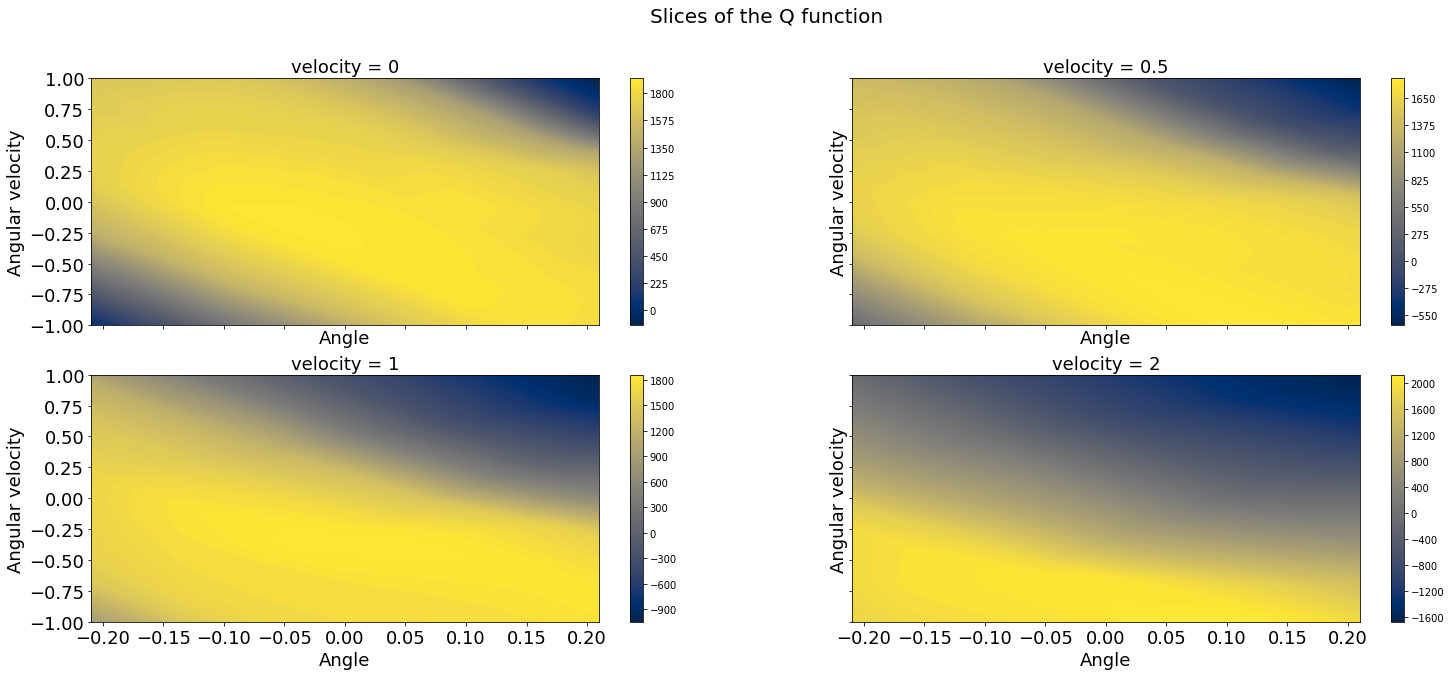

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))


fig, axs = plt.subplots(figsize = (25,10), ncols = 2, nrows = 2, sharex=True, sharey='row')
axs = axs.ravel()
velocities = [0, 0.5, 1, 2]
for c, v in enumerate(velocities):
  for i, angle in enumerate(angles):
      for j, omega in enumerate(omegas):
          state = torch.tensor([0., v, angle, omega]*k)
          with torch.no_grad():
              q_vals = policy_net(state)
              greedy_action = q_vals.argmax()
              greedy_q_array[i, j] = q_vals[greedy_action]
              policy_array[i, j] = greedy_action
  if q:
      contour = axs[c].contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
  else:
      contour = axs[c].contourf(angles, omegas, policy_array.T, cmap='cividis')
  axs[c].set(xlabel='Angle', ylabel='Angular velocity')
  axs[c].set_title(f"velocity = {v}")
  fig.colorbar(contour, ax=axs[c])

for i, ax in enumerate(axs.flat):
    for item in ([ax.xaxis.label, ax.yaxis.label, ax.title] + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(18)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Slices of the Q function', fontsize =20);
# fig.colorbar(contour)
fig.show()


#3 - Transform DQN into a DDQN

In [ ]:
runs_results, _ = train_model(model_name="ddqn")

comparison_results['DDQN'] = runs_results

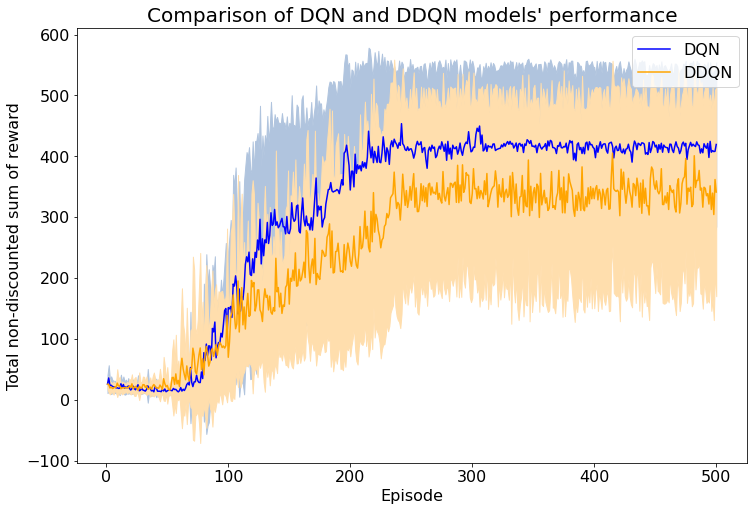

In [ ]:
colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))

for c, experiment in enumerate(comparison_results):
    
    results = torch.tensor(comparison_results[experiment])
    mean_rewards = results.float().mean(0)
    std_rewards = results.float().std(0)

    plt.plot(episodes, mean_rewards, color=colors[c], label=experiment);
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);

plt.title('Comparison of DQN and DDQN models\' performance', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()

In [ ]:
results = torch.tensor(comparison_results["DDQN"])
mean_rewards = results.float().mean(0)
print(torch.mean(mean_rewards))
print(max(mean_rewards))

tensor(246.1432)
tensor(405.3000)


In [ ]:
runs_results, _ = train_model(model_name="ddqn", k=4)

comparison_results['DDQN with k=4'] = runs_results

{'model_name': 'ddqn', 'epsilon_type': 'exponential_decay', 'NUM_ITERATIONS': 10, 'NUM_EPISODES': 500, 'BATCH_SIZE': 256, 'SYNC_TARGET': 75, 'EPSILON_PARAMETER': 0.985, 'BUFFER_SIZE': 125000, 'k': 4, 'use_early_stopping': True, 'target_update': 'step', 'num_hidden_layers': 3, 'size_hidden_layers': 75, 'loss_reduction': 'sum'}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  285


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  178


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  127


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  164


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  136


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  204


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  131


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  144


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  128


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping - episode  120
Complete


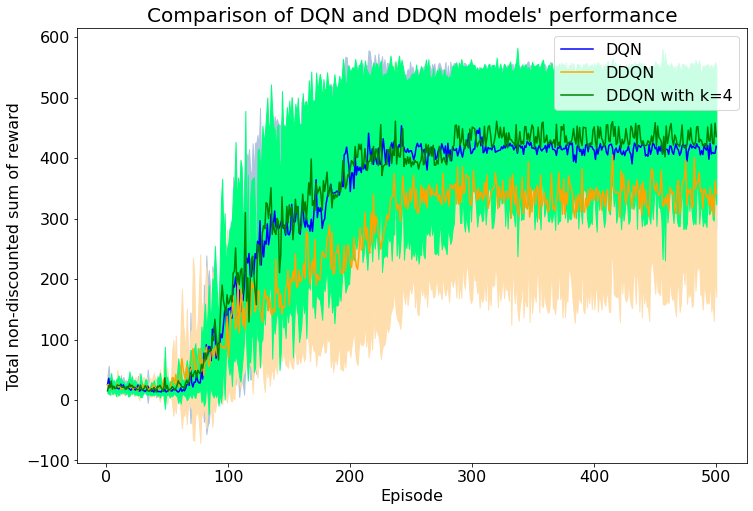

In [ ]:
colors = ['blue', 'orange', 'green', 'violet', 'gray', 'fuchsia']
std_colors = ['lightsteelblue', 'navajowhite', 'springgreen', 'thistle', 'lightgray', 'plum']

plt.figure(figsize = (12, 8));
episodes = list(range(1,NUM_EPISODES+1))

for c, experiment in enumerate(comparison_results):
    
    results = torch.tensor(comparison_results[experiment])
    mean_rewards = results.float().mean(0)
    std_rewards = results.float().std(0)

    plt.plot(episodes, mean_rewards, color=colors[c], label=experiment);
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards,color = std_colors[c]);

plt.title('Comparison of DQN and DDQN models\' performance', fontsize =20);
plt.xlabel('Episode',fontsize =16);
plt.ylabel('Total non-discounted sum of reward', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize =16);
plt.show()